https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ <br>
ДЗ - оценить возраст человека по изображению. В качестве датасета возьмите датасет только лиц.
Предположим что сами лица вы находить и извлекать уже умеете. Можете сделать это как продолжение решения по поиску лиц из предыдущих работ. <br>
https://www.google.com/amp/s/www.geeksforgeeks.org/age-detection-using-deep-learning-in-opencv/amp/ - пример того, как это может работать.  <br>
В качестве фьючеэкстрактора берите любую современную нейронную сеть. Задачу можно решать как задачу регрессии или классификации. <br>
Если есть время, можете попробовать 2 способа.  <br>
Попробуйте разблокировать часть слоев после обучения и дообучить модель. <br>
Указание -  чтобы решить задачу регресси вам нужно использовать flow_from_dataframe. <br>
Указание - для начала вам нужно создать датафрейм, в котором будет относительный путь к изображению и целевая метка, потом использовать этот датафрейм при обучении.



Алгоритм:
1. Разархивируем данные.
2. Открываем каждую картинку, проверяем, не битая ли она, выделяем лицо с помощью модели FaceDetection из mediapipe.
3. Сохраняем новое изображение с выделенным лицом, заносим путь к нему и соответствующую метку в dataframe.
4. В качестве меток используем натуральный логарифм от возраста человека, чтобы уменьшить диапазон по значениям.
5. Разделяем выборку на обучающую, валидационную и тетовую.
6. Загружаем предобученную модель ConvNeXtTiny в качестве экстрактора признаков.
7. Составляем обобщенную модель регрессии.
8. Проводим обучеие и тестироваие модели.


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip3 install mediapipe
!pip3 install keras_preprocessing


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import mediapipe as mp
import pandas as pd
import numpy as np
import tarfile
import random
import shutil
import math
import cv2
import os


In [ ]:
# initialize constants
FOLDER_PATH = '/content/drive/MyDrive/peleng-courses/HW_24'
CROPPED_IMGS_FOLDER = 'cropped_wikki'

INPUT_SHAPE = (224, 224, 3,)
SIZE_TH = 0.25
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
BATCH_SIZE = 32


In [ ]:
# extract tar.gz archive
def get_extracted_path():
    tar_path = None

    for folder in os.listdir(FOLDER_PATH):
        folder_path = os.path.join(FOLDER_PATH, folder)

        if os.path.isdir(folder_path) and 'cropped' not in folder:
            return folder_path

        if tarfile.is_tarfile(folder_path):
            tar_path = folder_path

    with tarfile.open(tar_path, 'r') as tar_gz_file:
        tar_gz_file.extractall(FOLDER_PATH)

    return tar_path.split('.')[0]


In [ ]:
extracted_path = get_extracted_path()
print('Folder with extracted pictures', extracted_path)


Folder with extracted pictures /content/drive/MyDrive/temp/wiki


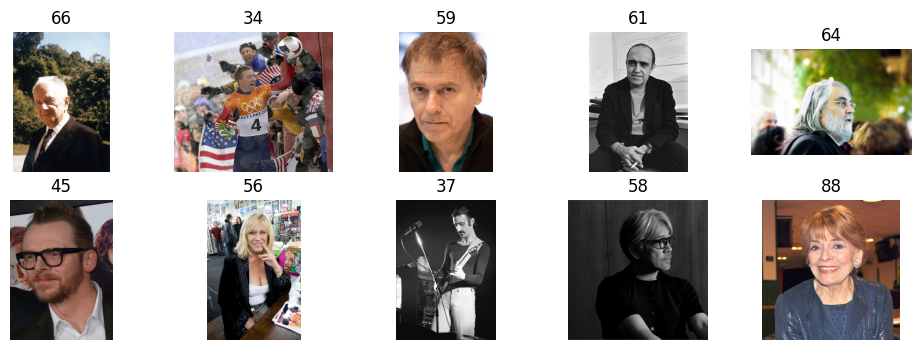

In [ ]:
# show images from dataset
plt.figure(figsize=(12, 4))
i = 1

for num_folder in os.listdir(extracted_path):
    if i > 10:
        break

    num_folder_path = os.path.join(extracted_path, num_folder)
    if not os.path.isdir(num_folder_path):
        continue

    for img_name in os.listdir(num_folder_path):
        if i > 10:
            break

        img = cv2.imread(os.path.join(num_folder_path, img_name),
                         cv2.IMREAD_COLOR_RGB)
        try:
            h, w, _ = img.shape
        except AttributeError:
            continue

        if h < 10 or w < 10:
            continue

        birth_year, photo_year = img_name.split('_')[1:]
        birth_year = int(birth_year.split('-')[0])
        photo_year = int(photo_year.split('.')[0])
        age = photo_year - birth_year

        if 0 < age < 100:
            plt.subplot(2, 5, i)
            plt.imshow(img)
            plt.title(str(age))
            plt.axis('off')
            i += 1


In [ ]:
# detect faces in images and crop they
imgs_df = pd.DataFrame(columns=['filename', 'raw', 'class'])

cropped_imgs_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER)
if not os.path.exists(cropped_imgs_path):
    os.mkdir(cropped_imgs_path)

with mp.solutions.face_detection.FaceDetection(
    min_detection_confidence=0.6, model_selection=1) as face_model:

    for num_folder in tqdm(os.listdir(extracted_path)):
        num_folder_path = os.path.join(extracted_path, num_folder)

        if not os.path.isdir(num_folder_path):
            continue

        for img_name in os.listdir(num_folder_path):
            img = cv2.imread(os.path.join(num_folder_path, img_name),
                             cv2.IMREAD_COLOR_RGB)
            try:
                imgh, imgw, _ = img.shape
            except AttributeError:
                continue

            birth_year, photo_year = img_name.split('_')[1:]
            birth_year = int(birth_year.split('-')[0])
            photo_year = int(photo_year.split('.')[0])
            crop_class = photo_year - birth_year

            if crop_class <= 0 or crop_class >= 100:
                continue

            result = face_model.process(img)
            if not result.detections:
                continue

            for (n, detection) in enumerate(result.detections):
                bbox = detection.location_data.relative_bounding_box
                xmin = math.floor(bbox.xmin * imgw)
                ymin = math.floor(bbox.ymin * imgh)
                width = math.ceil(bbox.width * imgw)
                height = math.ceil(bbox.height * imgh)

                if width / INPUT_SHAPE[0] > SIZE_TH and \
                 height / INPUT_SHAPE[1] > SIZE_TH:
                 continue

                cropped_img = img[ymin:ymin + height, xmin:xmin + width]
                if cropped_img.shape == () or 0 in cropped_img.shape:
                    continue

                cropped_name = f'{num_folder}_{img_name.split(".")[0]}{n}.png'
                cv2.imwrite(os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER, cropped_name),
                            cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))

                if imgs_df.empty:
                    imgs_df = pd.DataFrame(dict(zip(imgs_df.columns,
                     [cropped_name, crop_class, np.log(crop_class)])), index=[0])
                else:
                    imgs_df = imgs_df._append(pd.Series(dict(zip(imgs_df.columns,
                     [cropped_name, crop_class, np.log(crop_class)]))), ignore_index=True)


100%|██████████| 101/101 [21:54<00:00, 13.01s/it]


In [ ]:
print('Cropped images count:', len(imgs_df))


Cropped images count: 10641


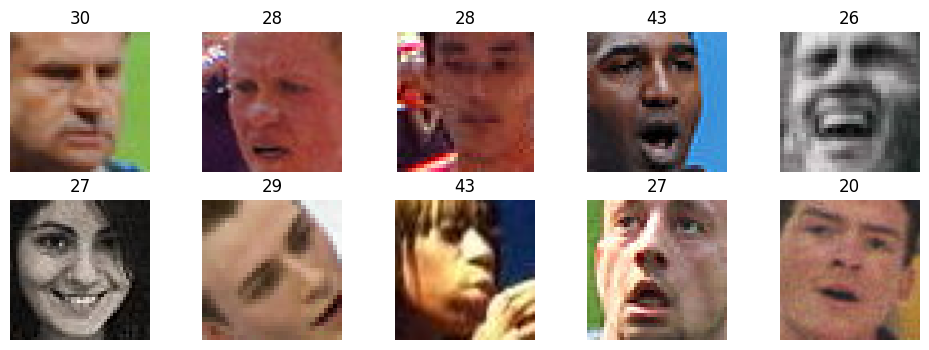

In [ ]:
# show cropped images from dataset
plt.figure(figsize=(12, 4))

for i in range(10):
    img_path = os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER,
                            imgs_df.loc[i, 'filename'])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(str(imgs_df.loc[i, 'raw']))
    plt.axis('off')


In [ ]:
# split images dataset into train, validation and test
train_idxs = random.sample(range(len(imgs_df)),
                           int(len(imgs_df) * TRAIN_SPLIT))
train_df = imgs_df.loc[train_idxs]

test_val_idxs = set(range(len(imgs_df))).difference(train_idxs)
val_idxs = random.sample(list(test_val_idxs),
                         int(len(imgs_df) * VAL_SPLIT))
val_df = imgs_df.loc[val_idxs]

test_idxs = test_val_idxs.difference(val_idxs)
test_df = imgs_df.loc[list(test_idxs)]

assert len(train_df) + len(val_df) + len(test_df) == len(imgs_df), '[WARNING] Check split!'

print('Train set size is', len(train_df),
      '\nValidation set size is', len(val_df),
      '\nTest set size is', len(test_df))


Train set size is 7448 
Validation set size is 1064 
Test set size is 2129


In [ ]:
# create data generator objects for load and augment dataset
train_datagen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=(-0.2, 0.2),
    zoom_range=0.3,
    channel_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER),
    target_size = INPUT_SHAPE[:2],
    class_mode='raw',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER),
    target_size = INPUT_SHAPE[:2],
    class_mode='raw',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(FOLDER_PATH, CROPPED_IMGS_FOLDER),
    target_size = INPUT_SHAPE[:2],
    class_mode='raw',
    batch_size=BATCH_SIZE,
    validate_filenames=False,
    shaffle=False
)


Found 7448 non-validated image filenames.
Found 1064 non-validated image filenames.
Found 2129 non-validated image filenames.


In [ ]:
# create features extractor model (ConvNeXtTiny)
extractor_model = tf.keras.applications.ConvNeXtTiny(input_shape=INPUT_SHAPE,
                                                     include_top=False)
extractor_model.trainable = False
extractor_model.summary()


In [ ]:
# create regression model with ConvNeXtTiny as features extractor
model = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    extractor_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='relu')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_tiny (Functional)           │ (None, 7, 7, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,820,128 (106.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,820,128 (106.13 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mse'])

model_path = os.path.join(FOLDER_PATH, 'best_model.keras')
chekpointer = ModelCheckpoint(model_path, save_best_only=True,
                              monitor='val_loss', mode='min')

lr_reducing = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, mode='min')


In [ ]:
# train model
EPOCHS = 20
history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[chekpointer, lr_reducing],
                    validation_data=val_generator)


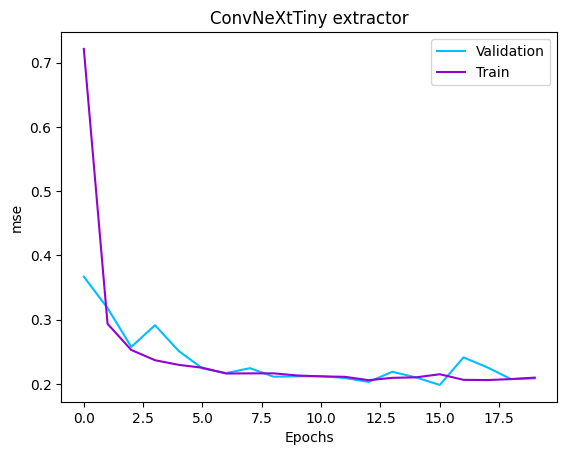

In [ ]:
# visualize training metrics
plt.plot(history.history['val_mse'], color='deepskyblue')
plt.plot(history.history['mse'], color='darkviolet')
plt.title('ConvNeXtTiny extractor')
plt.legend(['Validation', 'Train'])
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.show()


In [ ]:
# load saved best model
best_model = load_model(model_path)


In [ ]:
# calculate metrics from best model
metrics = best_model.evaluate(test_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - loss: 0.1950 - mse: 0.1950


В ходе работы была исползована модель ConvNeXtTiny для извлечния принаков. Как видно из кривой обучения, метрика MSE перестаетс изменятся раньше достижения 20ти эпох обучения, и ошибка на тестовой выборке составляет mse = 0.1950.